# Regression Modelle

# Setup
---

### Import Module & Libraries

Zu Beginn werden die benötigten Komponenten aus den entsprechenden Libraries importiert.

In [1]:
# Allgemein
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns 
sns.set_theme(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
import plotly.express as px
from patsy import dmatrix

# statsmodels
from statsmodels.compat import lzip
import statsmodels.api as sm
#from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.tools.tools import add_constant

# sklearn
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

### Erstellen einer Pipeline

Um die numerische und kategoriale Variablen automatisch in ein korrektes Format für die scikit learn Modelle zu transformieren, wird an dieser Stelle eine Pipeline definiert. Diese besteht aus verschiedenen Elementen, welche bspw. fehlende Werte ausfüllt (SimpleImputer) oder kategoriale Variablen in ein binäres Format umwandelt (OneHotEncoder).

In [2]:
# für numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

In [3]:
# für categorical features  
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

In [4]:
# Erstellen der Pipeline, zusammenführen von cat und numeric transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="category")),
    ('cat', categorical_transformer, selector(dtype_include="category"))
        ])

# Import Data
---

Als nächstes wird der Datensatz aus dem GitHub Repository importiert.

In [5]:
ROOT = "https://raw.githubusercontent.com/jan-kirenz/project-OliScha/main/"
DATA = "project_data.csv?token=GHSAT0AAAAAABPCEITIYHBIEPRTFMZJXUGKYPKREJQ"

df = pd.read_csv(ROOT + DATA)

Wir werfen einen ersten Blick auf die Daten um zu prüfen, auch um zu prüfen ob der Import funktioniert hat. Hier fällt direkt auf, dass die erste Observation durch Text und ein Währungszeichen verunreigt ist.

In [6]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
0,-122.23,37.88,41.0years,880,129.0,322,126,8.3252,452600.0$,NEAR BAY,above
1,-122.22,37.86,21.0,7099,1106.0,2401,1138,8.3014,358500.0,NEAR BAY,above
2,-122.24,37.85,52.0,1467,190.0,496,177,7.2574,352100.0,NEAR BAY,above
3,-122.25,37.85,52.0,1274,235.0,558,219,5.6431,341300.0,NEAR BAY,above
4,-122.25,37.85,52.0,1627,280.0,565,259,3.8462,342200.0,NEAR BAY,above
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665,374.0,845,330,1.5603,78100.0,INLAND,above
20636,-121.21,39.49,18.0,697,150.0,356,114,2.5568,77100.0,INLAND,above
20637,-121.22,39.43,17.0,2254,485.0,1007,433,1.7000,92300.0,INLAND,above
20638,-121.32,39.43,18.0,1860,409.0,741,349,1.8672,84700.0,INLAND,above


# Data Split
---

Direkt nach dem Import und einem ersten Blick auf die Daten werden die Daten in Traings- und Testdaten aufgeteilt. Alle folgenden Schritt finden auf Basis der Trainingsdaten statt, um möglichst realistische Ergebnisse bei der späteren Evaluation mit Testdaten zu erzielen.

Dadurch soll ein möglichst realistischer generalization error (or out-of-sample error) erzielt werden.

Bestimmte Schritte der Datenaufbereitung (datatypes, selbst erstellte Variablen etc.) müssen dann späte rallerdings auch für die Testdaten durchgeführt werden, um diese zur Evaluation nutzen zu können.

In [7]:
# Data Split
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

train_dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
14740,-117.05,32.58,22.0,2101,399.0,1551,371,4.1518,136900.0,NEAR OCEAN,below
10101,-117.97,33.92,32.0,2620,398.0,1296,429,5.7796,241300.0,<1H OCEAN,above
20566,-121.84,38.65,29.0,3167,548.0,1554,534,4.3487,200700.0,INLAND,above
2670,-115.60,33.20,37.0,709,187.0,390,142,2.4511,72500.0,INLAND,above
15709,-122.43,37.79,25.0,1637,394.0,649,379,5.0049,460000.0,NEAR BAY,above
...,...,...,...,...,...,...,...,...,...,...,...
7616,-118.22,33.86,16.0,8732,1489.0,3944,1493,5.1948,203500.0,<1H OCEAN,above
8767,-118.39,33.81,35.0,1008,165.0,391,167,3.7778,487500.0,NEAR OCEAN,above
16388,-121.30,38.05,52.0,122,26.0,62,25,1.1500,112500.0,INLAND,below
19949,-119.37,36.21,35.0,2228,476.0,1567,449,1.4455,54100.0,INLAND,above


# Data Inspection
---

### Anomaly Detection

In diesem Abschnitt werden die Daten genauer untersucht um Anomalien zu identifizieren und ggfs. zu bereinigen.

In [8]:
train_dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
14740,-117.05,32.58,22.0,2101,399.0,1551,371,4.1518,136900.0,NEAR OCEAN,below
10101,-117.97,33.92,32.0,2620,398.0,1296,429,5.7796,241300.0,<1H OCEAN,above
20566,-121.84,38.65,29.0,3167,548.0,1554,534,4.3487,200700.0,INLAND,above
2670,-115.60,33.20,37.0,709,187.0,390,142,2.4511,72500.0,INLAND,above
15709,-122.43,37.79,25.0,1637,394.0,649,379,5.0049,460000.0,NEAR BAY,above


Bereits beim ersten Blick auf das df ist aufgefallen, dass in der Observation mit Index = 0 die Variablen *housing_median_age* und *median_house_value* nicht dem Format der übrigen Daten in der gleichen Spalte entsprechen. Die Observation ist noch in unserem Traingsdatenset enthalten und muss in den nächsten Schritten bereinigt werden

In [9]:
train_dataset.loc[0, : ]


longitude               -122.23
latitude                  37.88
housing_median_age    41.0years
total_rooms                 880
total_bedrooms            129.0
population                  322
households                  126
median_income            8.3252
median_house_value    452600.0$
ocean_proximity        NEAR BAY
price_category            above
Name: 0, dtype: object

Diese Verunreinigung sorgt auch dafür, dass den Variablen *housing_median_age* und *median_house_value* automatisch der Datatype *object* zugewiesen wurde,
obwohl man eher einen numerischen Wert erwarten würde (float oder int). Dies muss auch nach der Bereinigung korrigiert werden.

In der Übresicht info() kann außerdem bereits erkannt werden, dass einige Observations in der Spalte *total_bedrooms* keinen Wert (NULL) vorliegen haben.



In [10]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14740 to 10078
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  object 
 3   total_rooms         16512 non-null  int64  
 4   total_bedrooms      16352 non-null  float64
 5   population          16512 non-null  int64  
 6   households          16512 non-null  int64  
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  object 
 9   ocean_proximity     16512 non-null  object 
 10  price_category      16512 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.0+ MB


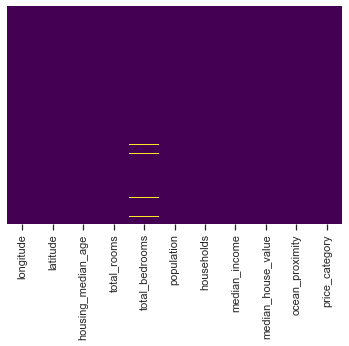

In [11]:
# Identifizieren der NULL Werte via Heatmap
sns.heatmap(train_dataset.isnull(), 
            yticklabels=False,
            cbar=False, 
            cmap='viridis');

In [12]:
# Identifizieren der NULL Werte via Liste
print(train_dataset.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        160
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
price_category          0
dtype: int64


Die 160 identifizierten Datensätze mit den NULL Values in der Variablen *total_bedrooms* werden im nächsten Schritt entfernt.  
Auf ein Ausfüllen der leeren Felder mit Mittelwert o.ä. wird hier verzichtet, da es sich hierbei lediglich um ca. 1% der Daten handelt und ein blindes Ausfüllen per mean auch Schaden anrichten könnte.

In [13]:
# Droppen der NULL values
train_dataset = train_dataset.dropna()

Die Variable *price_category* wird direkt aus unserer vorherzusagenden Variable *median_house_value* abgeleitet und einigt sich daher nicht als Feature.

In [14]:
# Droppen der nicht benötigten Variable
train_dataset = train_dataset.drop(columns=['price_category'])

Im nächsten Schritt wird der zuvor identifizierte verunreinigte Datensatz korrigiert. Da es sich nur um einen einzigen Datensatz handelt, könnte dieser ebenfalls gelöscht werden.  
Da allerdings die Daten vollständig vorhanden sind, sollen diese behalten und bereinigt werden.

In [15]:
# change datatype zu string um str.replace transformation durchzuführen
train_dataset['median_house_value'] = train_dataset['median_house_value'].astype("string")
train_dataset['housing_median_age'] = train_dataset['housing_median_age'].astype("string")

In [16]:
# Bereinigung der fehlerhaften Werte
train_dataset.median_house_value = train_dataset.median_house_value.str.replace("$", "", regex =True)
train_dataset.housing_median_age = train_dataset.housing_median_age.str.replace("years", "", regex =True)

### Schema Definition

Da nun alle offensichtlichen Anomalien in den Trainingsdaten entfernt wurden, sollen als nächstes die Datentypen der Variablen angepasstwerden.  
Numerische Variablen werden je nach Variable als *float* oder *int* definiert, kategoriale Varaiblen als *cat*.  
Die Varaiblen *housing_median_age*, *median_house_value* und *ocean_proximity* passen noch nicht in das Schema und müssen angepasst werden.
- *housing_median_age* --> float, da das Alter theoretisch auch in nicht gerundeten Werten angegeben werden könnte (bspw. 10,5 Jahre - was in unseren Daten allerdings nicht der Fall ist)
- *median_house_value* --> float, da Wert auch mit Nachkommastellen angegeben werden könnte
- *ocean_proximity* --> cat, dem Abstand zum Meer könnte theoretisch eine Reihenfolge zugewiesen werden
- *total_bedrooms* --> int, wie bei *total_rooms*, da es in der Regel keine halben Räume in Districts gibt.

In [17]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16352 entries, 14740 to 10078
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16352 non-null  float64
 1   latitude            16352 non-null  float64
 2   housing_median_age  16352 non-null  string 
 3   total_rooms         16352 non-null  int64  
 4   total_bedrooms      16352 non-null  float64
 5   population          16352 non-null  int64  
 6   households          16352 non-null  int64  
 7   median_income       16352 non-null  float64
 8   median_house_value  16352 non-null  string 
 9   ocean_proximity     16352 non-null  object 
dtypes: float64(4), int64(3), object(1), string(2)
memory usage: 1.4+ MB


In [18]:
train_dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14740,-117.05,32.58,22.0,2101,399.0,1551,371,4.1518,136900.0,NEAR OCEAN
10101,-117.97,33.92,32.0,2620,398.0,1296,429,5.7796,241300.0,<1H OCEAN
20566,-121.84,38.65,29.0,3167,548.0,1554,534,4.3487,200700.0,INLAND
2670,-115.60,33.20,37.0,709,187.0,390,142,2.4511,72500.0,INLAND
15709,-122.43,37.79,25.0,1637,394.0,649,379,5.0049,460000.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
7616,-118.22,33.86,16.0,8732,1489.0,3944,1493,5.1948,203500.0,<1H OCEAN
8767,-118.39,33.81,35.0,1008,165.0,391,167,3.7778,487500.0,NEAR OCEAN
16388,-121.30,38.05,52.0,122,26.0,62,25,1.1500,112500.0,INLAND
19949,-119.37,36.21,35.0,2228,476.0,1567,449,1.4455,54100.0,INLAND


In [19]:
# Anpassung der datatypes
train_dataset['median_house_value'] = train_dataset['median_house_value'].astype("float64")
train_dataset['housing_median_age'] = train_dataset['housing_median_age'].astype("float64")
train_dataset['total_bedrooms'] = train_dataset['total_bedrooms'].astype("int64")
train_dataset['ocean_proximity'] = train_dataset['ocean_proximity'].astype("category")


# Deskriptive Statistik
---

In diesem Abschnitt sollen die Variablen genauer auf statistische Merkmale untersucht werden.  
Zuerst werden die numerischen Variablen betrachtet.

In [20]:
# Zusammenfassung für alle numerischen Varaiblen
round(train_dataset.describe(),1).transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,16352.0,-119.6,2.0,-124.4,-121.8,-118.5,-118.0,-114.3
latitude,16352.0,35.6,2.1,32.5,33.9,34.3,37.7,42.0
housing_median_age,16352.0,28.6,12.6,1.0,18.0,29.0,37.0,52.0
total_rooms,16352.0,2625.3,2151.9,2.0,1449.8,2122.0,3133.0,39320.0
total_bedrooms,16352.0,535.9,416.5,1.0,295.0,434.0,644.0,6445.0
population,16352.0,1420.3,1100.8,3.0,787.0,1163.0,1724.0,28566.0
households,16352.0,497.5,377.2,1.0,280.0,408.0,602.0,6082.0
median_income,16352.0,3.9,1.9,0.5,2.6,3.5,4.7,15.0
median_house_value,16352.0,206867.1,115747.7,14999.0,119400.0,179400.0,265000.0,500001.0


Folgende Auffälligkeiten sind hier zu sehen:
- Bei den Variablen *total_rooms*,*total_bedrooms*, *population* und *households* liegt der höchste Wert über dem 10 fachen des Wertes des 3 Quartils. Das deutet darauf ein, dass es einen oder wenige Distrikte gibt, welche viel größer sind als die Mehrzahl der Distrikte. Dies könnte im Feature Engineering ausgeglichen werden, indem durch Durchschnitsswerte die größe des Distrikts relativiert wird (bspw. Räume pro Person anstatt Räume im gesamten Distrikt)
- Bei der Variablen *median_income* fällt auf, dass der höchste Werte sehr hoch liegt im Vergleich zur Verteilung auf die Quartile (75% liegen unter 4.7, max bei 15.0)

>MEHR BESCHREIBEN

Als nächstes werden die kategorialen Variablen betrachtet.

In [21]:
train_dataset.describe(include=["category"]).transpose()

,count,unique,top,freq
ocean_proximity,16352,5,<1H OCEAN,7225


In [22]:
train_dataset['ocean_proximity'].value_counts()

<1H OCEAN     7225
INLAND        5228
NEAR OCEAN    2107
NEAR BAY      1788
ISLAND           4
Name: ocean_proximity, dtype: int64

In [23]:
train_dataset['ocean_proximity'].value_counts(normalize=True)

<1H OCEAN     0.441842
INLAND        0.319716
NEAR OCEAN    0.128853
NEAR BAY      0.109344
ISLAND        0.000245
Name: ocean_proximity, dtype: float64

Da die kategoriale Variable *price_category* bereits entfernt wurde, existiert nur noch *ocean_proximity* als kategoriale Variable. Diese hat fünf Ausprägungen. Vor allem die Ausprägung *ISLAND* ist mit nur vier Observation sehr schwach vertreten. Diese könnte man ggfs. später mit anderen ähnlichen Ausprägungen zusammenführen.

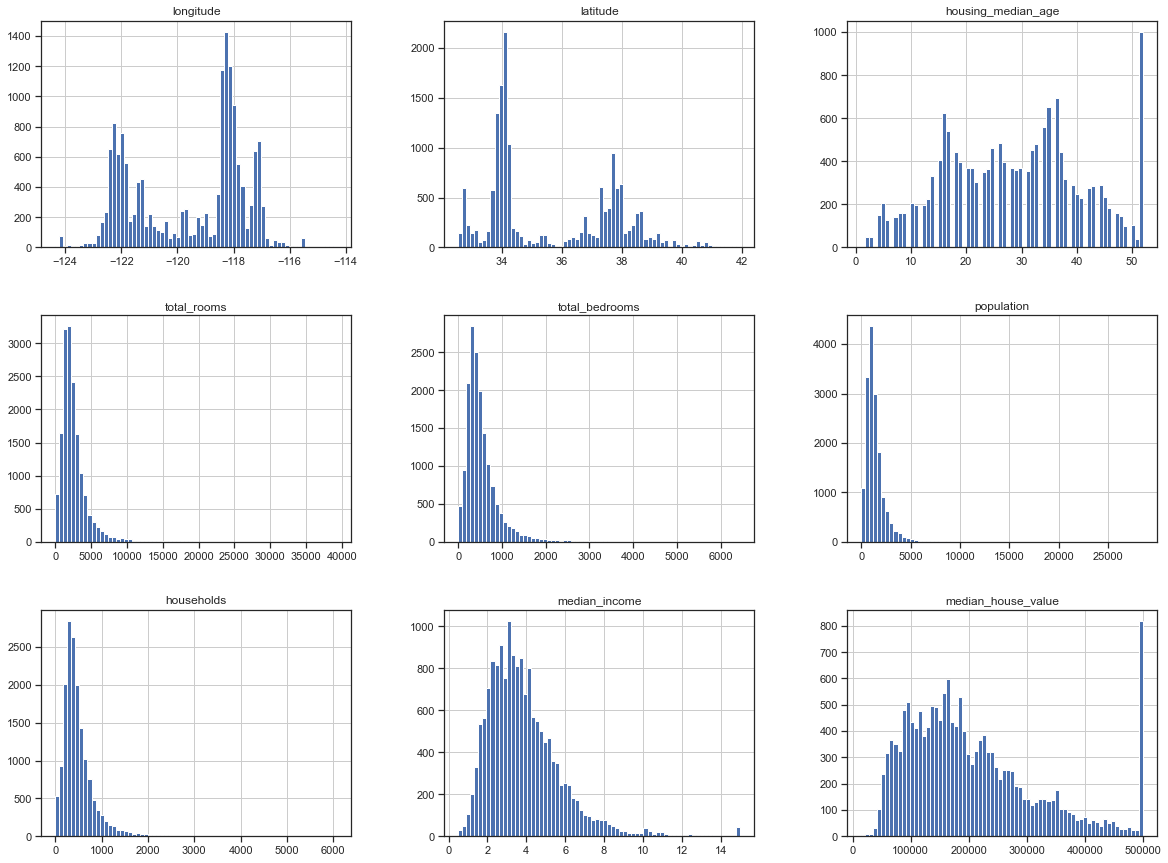

In [24]:
# Erstellen von Histogrammen
train_dataset.hist(bins=70, figsize=(20,15))
plt.show()

Bei einem Blick auf die Histogramme fällt auf, dass es bei unserer vorherzusagenden Variablen *median_house_value* eine große Anzahl an Observations gibt, die einen extrem hohen Wert besitzen (ca. 500.000$).  
Auch bei *housing_median_age* gibt es eine auffällig große Menge an Observations mit dem größten Wert (52 Jahre).

Evtl. wurden bei der Datenerhebung alle Werte größer den hier auffälligen Werten auf diesen Höchstwert gesetzt. Das könnte die Datenlage erklären, lässt sich in diesem Fall allerdings nicht klären.

Bei den Geokoordinaten fällt auf, dass sich Observations um bestimmte Koordinaten herum häufen. Das kann auf Bevölkerungsdichte Regionen mit vielen Distrikten hinweisen, wie bspw. bei großen Städten.

# Exploratory Data Analysis
---

## Überblick

Nachdem die statistischen Besonderheiten berachtet wurden, soll nun die Verteilung der Variablen sowie deren Abhängigkeiten untereinander sowie auf die vorherzusagende Variable untersucht werden.

In [25]:
# Pairplot für numerische Variablen mit Farbmarkierung für ocean_proximity
sns.pairplot(data=train_dataset, hue="ocean_proximity");

KeyboardInterrupt: 

**Erkenntnis:** 
- Einfluss auf Y Variable: Ein Zusammenhang zwischen *median_income* und *median_house_value* ist zu erkennen, ansonsten gibt es erstmal keine weiteren offensichtlichen Zusammenhänge.  
- Variablen untereinander: Es gibt starke lineare Zusammenhänge zwischen *total_rooms*, *total_bedrooms*, *households* und *population*. Das ist soweit logisch und muss bei der Modellierung später beachtet werden (Collinearity).

Auch an Hand der Korrelationswerte lässt sich erkennen, dass lediglich *median_income* einen starken Einfluss auf *median_house_value* hat.

In [331]:
corr = train_dataset.corr()
corr['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686220
total_rooms           0.131430
housing_median_age    0.107960
households            0.064087
total_bedrooms        0.048334
population           -0.028566
longitude            -0.044550
latitude             -0.146066
Name: median_house_value, dtype: float64

In [332]:
# Create correlation matrix for numerical variables
corr_matrix = train_dataset.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.923717,-0.107507,0.043284,0.068231,0.098328,0.054403,-0.016315,-0.044550
latitude,-0.923717,1.000000,0.007414,-0.033678,-0.065700,-0.108429,-0.070936,-0.077886,-0.146066
housing_median_age,-0.107507,0.007414,1.000000,-0.357994,-0.314841,-0.293407,-0.295959,-0.116747,0.107960
total_rooms,0.043284,-0.033678,-0.357994,1.000000,0.928974,0.858447,0.916588,0.197242,0.131430
total_bedrooms,0.068231,-0.065700,-0.314841,0.928974,1.000000,0.879519,0.978453,-0.010107,0.048334
population,0.098328,-0.108429,-0.293407,0.858447,0.879519,1.000000,0.910632,0.002679,-0.028566
households,0.054403,-0.070936,-0.295959,0.916588,0.978453,0.910632,1.000000,0.010742,0.064087
median_income,-0.016315,-0.077886,-0.116747,0.197242,-0.010107,0.002679,0.010742,1.000000,0.686220
median_house_value,-0.044550,-0.146066,0.107960,0.131430,0.048334,-0.028566,0.064087,0.686220,1.000000


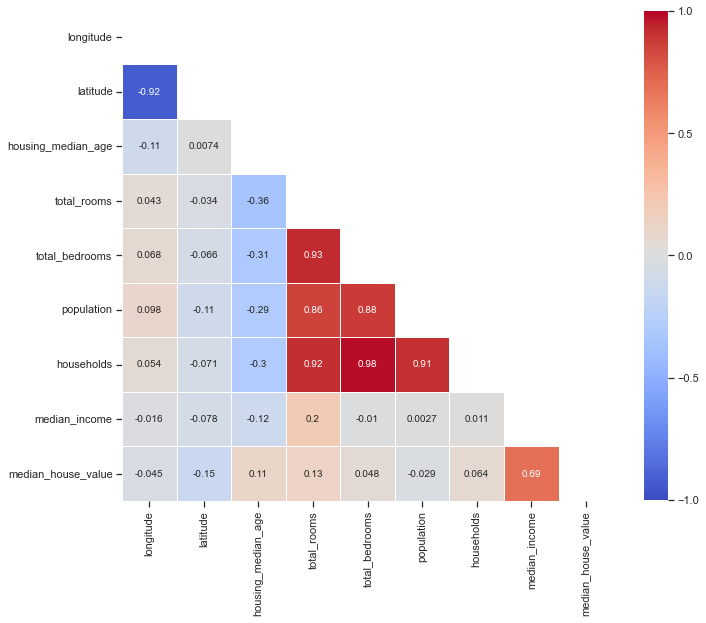

In [333]:
# Erstellen einer Heatmap um Abhängigkeiten zwischen den verschiedenen Variablen zu visualisieren

# Use a mask to plot only part of a matrix
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]= True

# Erstellen der Heatmap mit zusätzlichen Parametern
plt.subplots(figsize=(11, 15))
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask, 
                      square = True, 
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .6,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 10})

Die oben bereits erkannten Zusammenhänge lassen sich hier nochmal einen Blick bestätigen.

---

#### Analyse kategorialer Variablen

Als nächstes wird die kategoriale Variable *ocean_proximity* näher untersucht.

In [334]:
train_dataset['ocean_proximity'].value_counts()

<1H OCEAN     7225
INLAND        5228
NEAR OCEAN    2107
NEAR BAY      1788
ISLAND           4
Name: ocean_proximity, dtype: int64

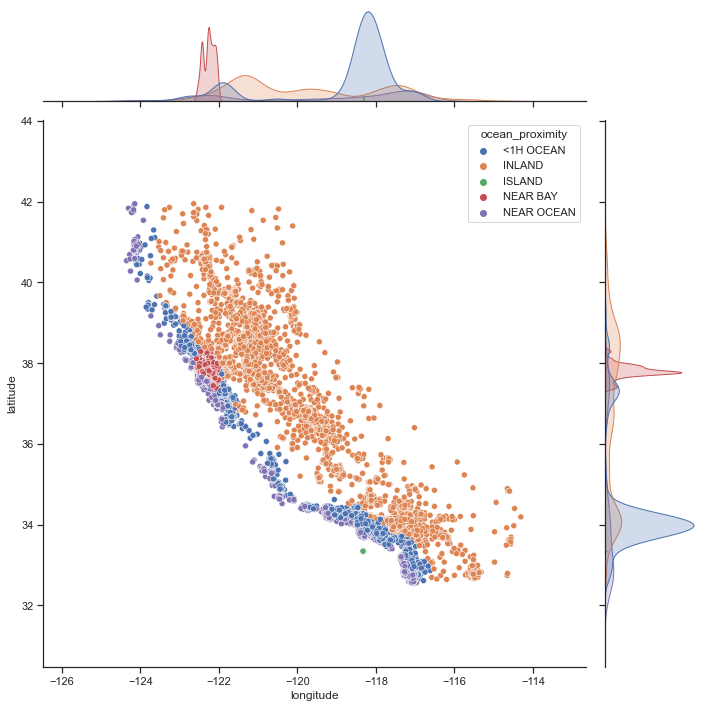

In [335]:
# Verteilung von ocean_proximity auf Geokoordinaten visualisieren
sns.jointplot(data=train_dataset, x='longitude', y='latitude', hue="ocean_proximity",height=10);


Auf Basis der Geokoordinaten und der Form lässt sich feststellen, dass es sich bei unserem Datensatz um Distrikte aus Kalifornien handelt.  
Auf dem Plot lässt sich erkennen, dass sich die Ausprägungen *ISLAND* und *NEAR BAY* sehr stark auf bestimmte Gebiete beschränken. Die anderen Ausprägungen sind einigermaßen gleichmäßig und nach einer Logik mit Abstand zum Meer verteilt.

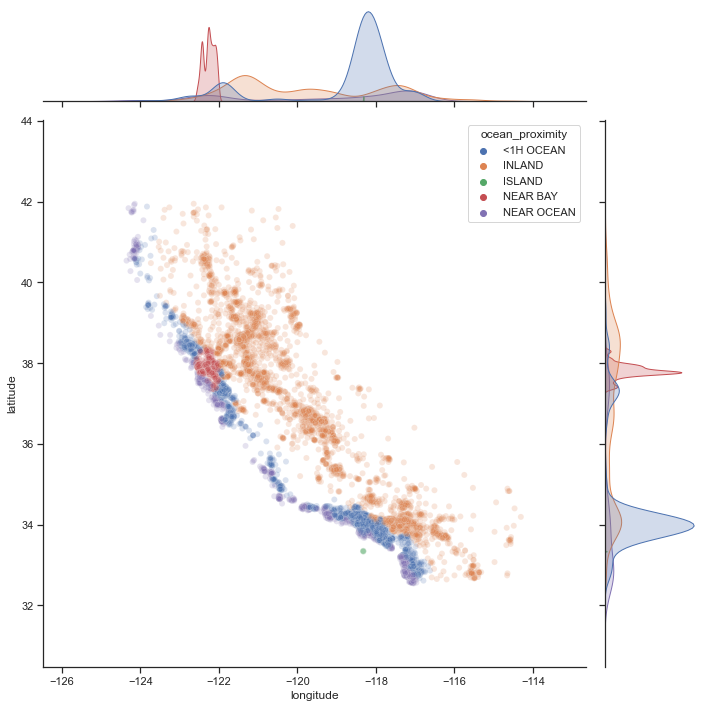

In [336]:
# Visualisierung Dichte
sns.jointplot(data=train_dataset, x='longitude', y='latitude', hue="ocean_proximity",height=10, alpha=0.2 );

Durch eine kleine Änderung in den Parametern des Plots lassen sich besonders gut die Gebiete erkennen, aus welchen viele Observations vorliegen. Wie bereits vermutet handelt es sich vor allem um Ballungszentren bei San Francisco und Los Angeles.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


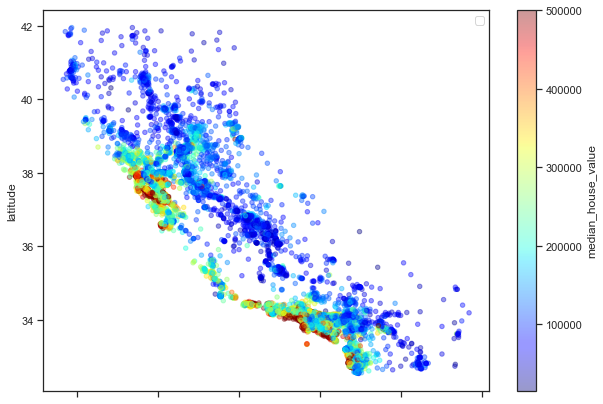

In [337]:
train_dataset.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7),c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

Mit Hilfe eines erweiterten Scatterplots können wir sogar visualisieren, wo die Distrikts mit den hohen *median_house_value* liegen. Wie zu erwarten war handelt es sich ebenfalls um die Gebiete rund um San Francisco und Los Angeles.

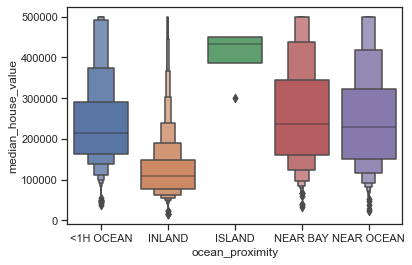

In [338]:
# Untersuchung der kategroialen Variable "ocean_proximity" mit einem erweiterten Boxplot
sns.boxenplot(data=train_dataset, x="ocean_proximity", y="median_house_value");

Durch ein erweitertes Boxplot Diagramm können wir erkennen, dass die Verteilung von *median_house_value* in den Ausprägungen *<1H OCEAN, NEAR BAY* und *NEAR OCEAN* sehr ähnlich ist. *INLAND* und *ISLAND* unterscheiden sich davon stark. Ggfs. könnte es Sinn machen, die ähnlichen Ausprägungen zusammenzufassen, das soll jedoch zuerst in den Modellen getestet werden.

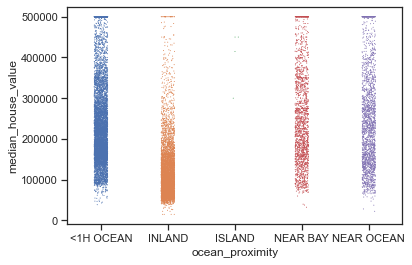

In [339]:
# Ergänzung zum Boxplot um Menge und Dichte der Observations zu visualisieren
sns.stripplot(data=train_dataset, x="ocean_proximity", y="median_house_value" , size=1 );

Durch eine andere Form der Darstellung lässt sich nochmal gut die Menge und Dicht der Observations erkennen - und dass für *ISLAND* nur sehr wenige Observations vorliegen.

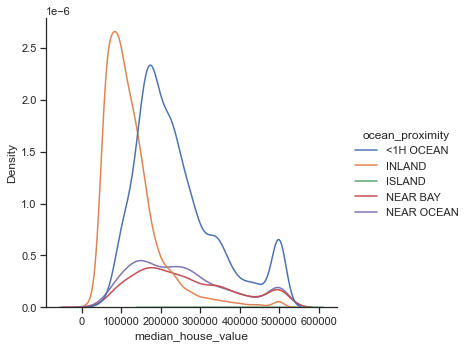

In [340]:
# Analyse von "ocean_proximity" mit displot
sns.displot(data=train_dataset, x="median_house_value", hue = "ocean_proximity", kind="kde" )

>**Fazit:** Die kategoriale Variable *ocean_proximity* hat definitiv Einfluss auf unsere vorherzusagende Variable. *INLAND* ist bspw. tenedneziell günstiger als die Distrikte, die näher am Meer liegen.   
Auffällig ist, das es für die Ausprägung *ISLAND* nur sehr wenige Observations gibt und *ISLAND* und *NEAR BAY* stark auf bestimmte Gebiete beschränkt sind.

#### Analyse numerischer Variablen

Vor allem die numerische Variable *median_income* sieht auf Basis des zu Beginn erstellen pairplots vielversprechend aus und wird daher nun näher untersucht. Aber auch andere numerische Varaiblen sollen noch genauer betrachtet werden.

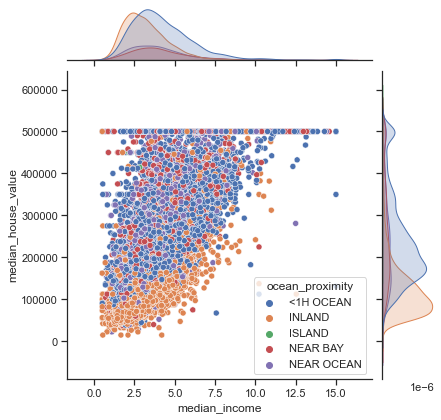

In [341]:
# Analyse der Variablen "median_income"
sns.jointplot(data=train_dataset, x='median_income', y='median_house_value', hue="ocean_proximity" );

Wie bereits im Parplot lässt sich hier nochmal gut erkennen, dass tendenziell mit steigendem *median_income* auch der *median_house_value* steigt.

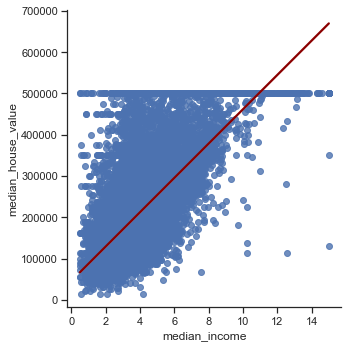

In [342]:
sns.lmplot(x='median_income', y='median_house_value', data=train_dataset, line_kws={'color': 'darkred'}, ci=False);

Analyse "total_rooms"

<AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>

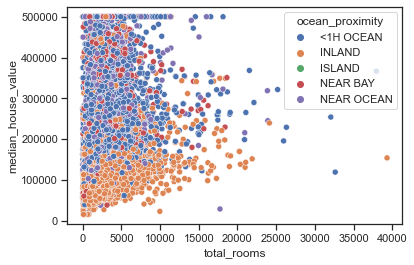

In [343]:
sns.scatterplot(data=train_dataset, x='total_rooms', y='median_house_value', hue="ocean_proximity" )

Auch bei *total_rooms* lääst sich ein leichter Trend erkennen. Da es sich allerdings hier um die Gesamtzahl der Räume in einem Distrikt handelt, welche natürlich direkt abhängig von dessen Größe ist, ist diese Variable möglicherweise nicht besonders gut geeignet. Viel besser wäre eine Variable, die die Anzahl der Räume in Relation setzt zur Anzahl an Haushalten oder Menschen. So eine Variable kann später im Feature Engineering erstellt werden.

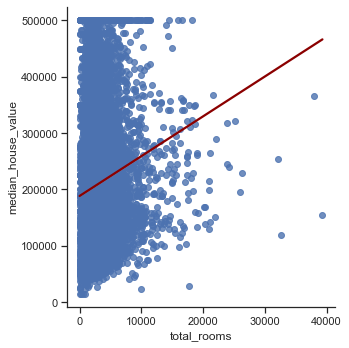

In [344]:
sns.lmplot(x='total_rooms', y='median_house_value', data=train_dataset, line_kws={'color': 'darkred'}, ci=False);

Analyse "housing_median_age"

<AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>

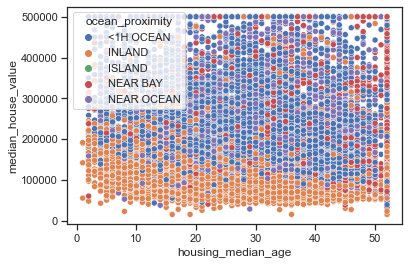

In [345]:
sns.scatterplot(data=train_dataset, x='housing_median_age', y='median_house_value', hue="ocean_proximity" )

Bei der Variable *housing_median_age* könnte man eine Auswirkung auf median_house_value erwarten, da neuere Häuser teurer sein könnten als alte Häuser. Anhand der Analyse lässt sich jedoch erkennen, dass diese Auswirkung nur sehr gering ist. Das könnte man bspw. durch teure Altbauwohungen oder durchgeführte Instandhaltungsmaßnahmen erklären.

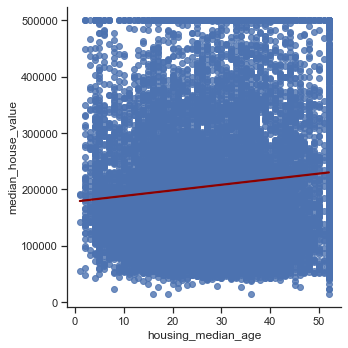

In [346]:
sns.lmplot(x='housing_median_age', y='median_house_value', data=train_dataset, line_kws={'color': 'darkred'}, ci=False);

>**Fazit:** Wie bereits erwartet bietet die Variable *median_income* das höchste Potential zur Vorhersage von *median_house_value*. Auch *ocean_proximity* zeigt eindeutig Auswirkungen auf unsere Y Variable, kann aber ggfs. noch zusammengefasst werden um später die Modelle zu optimieren. Auch bei weiteren Variablen kann Einfluss auf Y gefunden werden, allerdings ist dieser sehr schwach und sollte im Feauture Engineering optimiert werden.

# Initial Feature Engineering
---

## Erstellen eigener Variablen

In [347]:
# Erstellen neuer Variablen
train_dataset=train_dataset.assign(people_per_household=lambda train_dataset: train_dataset.population/train_dataset.households)
train_dataset=train_dataset.assign(bedrooms_per_household=lambda train_dataset: train_dataset.total_bedrooms/train_dataset.households)
train_dataset=train_dataset.assign(rooms_per_household=lambda train_dataset: train_dataset.total_rooms/train_dataset.households)
train_dataset=train_dataset.assign(bedrooms_per_room=lambda train_dataset: train_dataset.total_bedrooms/train_dataset.total_rooms)

## Analyse & Optimierung

In [348]:
corr = train_dataset.corr()
corr['median_house_value'].sort_values(ascending=False)

median_house_value        1.000000
median_income             0.686220
rooms_per_household       0.138533
total_rooms               0.131430
housing_median_age        0.107960
households                0.064087
total_bedrooms            0.048334
people_per_household     -0.021874
population               -0.028566
longitude                -0.044550
bedrooms_per_household   -0.047168
latitude                 -0.146066
bedrooms_per_room        -0.253441
Name: median_house_value, dtype: float64

Anhand der Matrix lässt sich erkennen, dass von den neu erstellten Varaiblen vor allem *bedrooms_per_room* und *rooms_per_household* einen Einfluss auf die vorherzusagende Variable *median_house_value* haben.

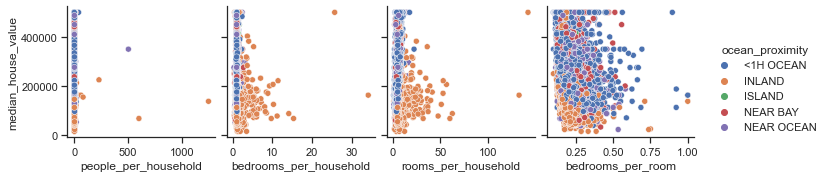

In [349]:
#Analyse neu erstellter Variablen
sns.pairplot(data=train_dataset, y_vars=["median_house_value"], x_vars=["people_per_household", "bedrooms_per_household", "rooms_per_household", "bedrooms_per_room"], hue="ocean_proximity");

Hier lassen sich Outlier bei *people_per_household*, *bedrooms_per_household* und *rooms_per_household* erkennen. Diese können später entfernt werden.

<AxesSubplot:xlabel='bedrooms_per_room', ylabel='median_house_value'>

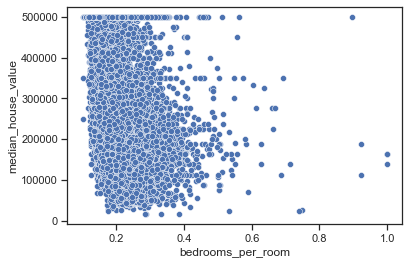

In [350]:
sns.scatterplot(data=train_dataset, x='bedrooms_per_room', y='median_house_value')

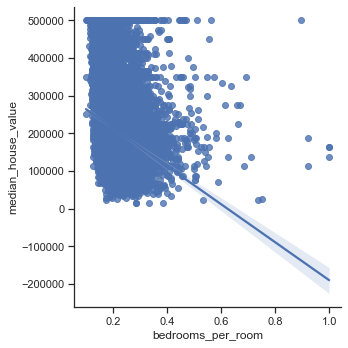

In [351]:
sns.lmplot(data=train_dataset, x='bedrooms_per_room', y='median_house_value');

<AxesSubplot:xlabel='rooms_per_household', ylabel='median_house_value'>

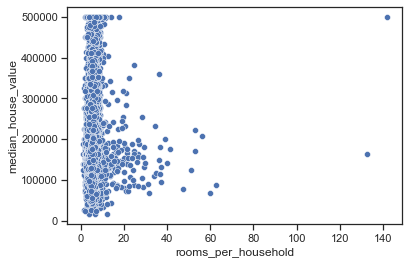

In [352]:
sns.scatterplot(data=train_dataset, x='rooms_per_household', y='median_house_value')

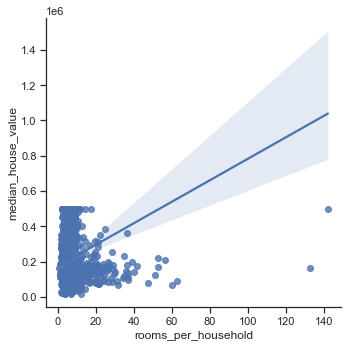

In [353]:
sns.lmplot(data=train_dataset, x='rooms_per_household', y='median_house_value');


<AxesSubplot:xlabel='people_per_household', ylabel='median_house_value'>

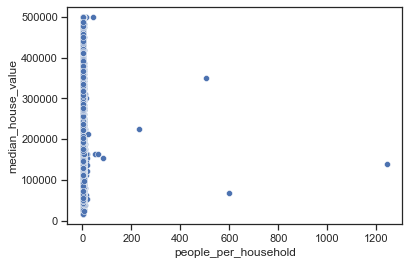

In [354]:
sns.scatterplot(data=train_dataset, x='people_per_household', y='median_house_value')

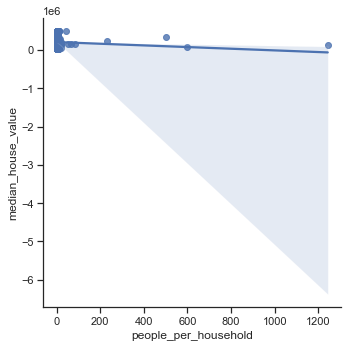

In [355]:
sns.lmplot(data=train_dataset, x='people_per_household', y='median_house_value');

Die zuvor auf dem Scatterplot aufgefallenen Outliers von *people_per_household* sollen nun identifiziert und entfernt werden. Distrikte, in denen im Schnitt mehrere hundert Menschen in einem Haushalt leben klingen nach fehlerhaften Daten (Unterschiedliche Methode in der Erfassung der Daten, Tippfehler etc.)

In [356]:
train_dataset.nlargest (10,'people_per_household')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,people_per_household,bedrooms_per_household,rooms_per_household,bedrooms_per_room
19006,-121.98,38.32,45.0,19,5,7460,6,10.2264,137500.0,INLAND,1243.333333,0.833333,3.166667,0.263158
3364,-120.51,40.41,36.0,36,8,4198,7,5.5179,67500.0,INLAND,599.714286,1.142857,5.142857,0.222222
16669,-120.70,35.32,46.0,118,17,6532,13,4.2639,350000.0,NEAR OCEAN,502.461538,1.307692,9.076923,0.144068
13034,-121.15,38.69,52.0,240,44,6675,29,6.1359,225000.0,INLAND,230.172414,1.517241,8.275862,0.183333
9172,-118.59,34.47,5.0,538,98,8733,105,4.2391,154600.0,INLAND,83.171429,0.933333,5.123810,0.182156
12104,-117.33,33.97,8.0,152,19,1275,20,1.6250,162500.0,INLAND,63.750000,0.950000,7.600000,0.125000
16420,-121.29,37.89,26.0,161,27,1542,30,5.7485,162500.0,INLAND,51.400000,0.900000,5.366667,0.167702
8874,-118.45,34.06,52.0,204,34,1154,28,9.3370,500001.0,<1H OCEAN,41.214286,1.214286,7.285714,0.166667
5986,-117.71,34.10,52.0,567,152,2688,126,1.8750,212500.0,INLAND,21.333333,1.206349,4.500000,0.268078
20352,-119.09,34.22,8.0,40,10,309,16,4.0208,52500.0,NEAR OCEAN,19.312500,0.625000,2.500000,0.250000


In [357]:
train_dataset.nlargest (10,'rooms_per_household')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,people_per_household,bedrooms_per_household,rooms_per_household,bedrooms_per_room
1914,-120.10,38.91,33.0,1561,282,30,11,1.8750,500001.0,INLAND,2.727273,25.636364,141.909091,0.180653
1979,-120.08,38.80,34.0,1988,511,36,15,4.6250,162500.0,INLAND,2.400000,34.066667,132.533333,0.257042
12447,-114.49,33.97,17.0,2809,635,83,45,1.6154,87500.0,INLAND,1.844444,14.111111,62.422222,0.226059
11862,-121.25,40.27,25.0,958,245,28,16,2.6250,67500.0,INLAND,1.750000,15.312500,59.875000,0.255741
1912,-120.16,39.01,16.0,1463,264,54,26,4.9750,206300.0,INLAND,2.076923,10.153846,56.269231,0.180451
9676,-119.02,37.64,14.0,5919,1278,265,112,3.2431,221400.0,INLAND,2.366071,11.410714,52.848214,0.215915
11707,-120.06,39.15,22.0,2213,372,98,42,1.1912,170000.0,INLAND,2.333333,8.857143,52.690476,0.168098
2395,-119.34,37.12,23.0,1881,380,64,37,3.8750,125000.0,INLAND,1.729730,10.270270,50.837838,0.202020
1240,-120.19,38.42,11.0,1568,369,82,33,3.1250,77500.0,INLAND,2.484848,11.181818,47.515152,0.235332
11832,-120.33,39.30,16.0,868,178,44,21,3.0000,175000.0,INLAND,2.095238,8.476190,41.333333,0.205069


In [358]:
train_dataset.nlargest (10,'bedrooms_per_household')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,people_per_household,bedrooms_per_household,rooms_per_household,bedrooms_per_room
1979,-120.08,38.80,34.0,1988,511,36,15,4.6250,162500.0,INLAND,2.400000,34.066667,132.533333,0.257042
1914,-120.10,38.91,33.0,1561,282,30,11,1.8750,500001.0,INLAND,2.727273,25.636364,141.909091,0.180653
11862,-121.25,40.27,25.0,958,245,28,16,2.6250,67500.0,INLAND,1.750000,15.312500,59.875000,0.255741
12447,-114.49,33.97,17.0,2809,635,83,45,1.6154,87500.0,INLAND,1.844444,14.111111,62.422222,0.226059
9676,-119.02,37.64,14.0,5919,1278,265,112,3.2431,221400.0,INLAND,2.366071,11.410714,52.848214,0.215915
1240,-120.19,38.42,11.0,1568,369,82,33,3.1250,77500.0,INLAND,2.484848,11.181818,47.515152,0.235332
2395,-119.34,37.12,23.0,1881,380,64,37,3.8750,125000.0,INLAND,1.729730,10.270270,50.837838,0.202020
1912,-120.16,39.01,16.0,1463,264,54,26,4.9750,206300.0,INLAND,2.076923,10.153846,56.269231,0.180451
1102,-121.54,40.06,17.0,858,262,47,27,2.4028,67500.0,INLAND,1.740741,9.703704,31.777778,0.305361
1872,-119.93,38.94,27.0,1709,408,97,44,2.4917,200000.0,INLAND,2.204545,9.272727,38.840909,0.238736


In [359]:
# people_per_household outlier droppen
train_dataset = train_dataset.drop(index=[19006,3364,16669,13034])
# rooms_per_household outlier droppen
train_dataset = train_dataset.drop(index=[1914,1979])
# bedrooms_per_household bereits in anderen enthalten und gedropped


Nach dem Entfernen der Outlier lässt sich eine stärke Auswirkung der Features auf die Y Variable erkennen

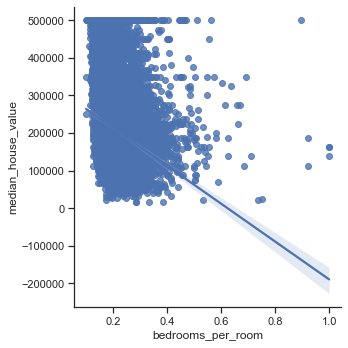

In [360]:
sns.lmplot(data=train_dataset, x='bedrooms_per_room', y='median_house_value');

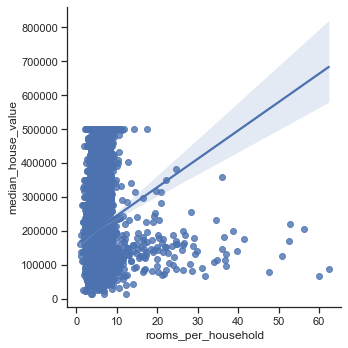

In [361]:
sns.lmplot(data=train_dataset, x='rooms_per_household', y='median_house_value');

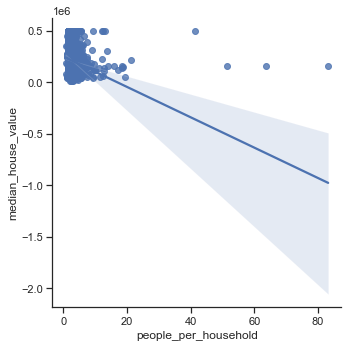

In [362]:
sns.lmplot(data=train_dataset, x='people_per_household', y='median_house_value');

In [363]:
corr = train_dataset.corr()
corr['median_house_value'].sort_values(ascending=False)

median_house_value        1.000000
median_income             0.687062
rooms_per_household       0.158067
total_rooms               0.131529
housing_median_age        0.107943
households                0.064261
total_bedrooms            0.048417
population               -0.028492
longitude                -0.044560
bedrooms_per_household   -0.068008
latitude                 -0.146165
people_per_household     -0.161934
bedrooms_per_room        -0.253301
Name: median_house_value, dtype: float64

## Auswahl Features

Auf Basis der vorhergegangenen Analysen sollen nun vorläufige Features zur Modellierung ausgewählt werden. Da nicht mehrere Features gewählt werden sollten, welche sich aus den selben Variablen berechnen, wird jeweils die Variable mit der vielversprechendsten Correlation zu Y ausgewählt (bspw. *bedrooms_per_room* > *rooms_per_household* ).
- *median_income*
- *bedrooms_per_room*
- *people_per_household*
- *ocean_proximity*
- *housing_median_age*

Obwohl *latitude* auch eine vielversprechende Correlation zeigt, wird diese Varaible nicht als feature für die Modelle ausgewählt, da geografische Informationen bereits in *ocean_proximity* enthalten sind.

In [364]:

# choose features and add constant
features = add_constant(train_dataset[['median_house_value', 'median_income','bedrooms_per_room','people_per_household','housing_median_age']])
# create empty DataFrame
vif = pd.DataFrame()
# calculate vif
vif["VIF Factor"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
# add feature names
vif["Feature"] = features.columns

vif.round(2)

C:\Users\olive\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,VIF Factor,Feature
0,56.59,const
1,2.30,median_house_value
2,3.29,median_income
3,1.76,bedrooms_per_room
4,1.04,people_per_household
5,1.09,housing_median_age


Um unsere ausgewählten Variablen auf Multikollinearität zu untersuchen, berechnen wir den Variance Inflation Factor (VIF). Da sich dieser bei allen Variablen unter 5 befindet, stellt die Kollinearität bei diesen Variablen kein Problem dar.

## Ergänzung

Nach Durchlauf mehrerer Modelle wird folgendes ergänzt:  
Die Ausprägungen *ISLAND*, *NEAR* *BAY* und *NEAR* *OCEAN* der Variablen *ocean_proximity* wurden in verschiedenen Modellen (Classification & Regression) durch P-Values oder Koeffizienten als unwichtig eingestuft.
Daher werden diese nun zu einer Ausprägung zusammengefasst.

In [365]:
train_dataset.ocean_proximity = train_dataset.ocean_proximity.str.replace("ISLAND", "NEAR WATER", regex =True)
train_dataset.ocean_proximity = train_dataset.ocean_proximity.str.replace("NEAR BAY", "NEAR WATER", regex =True)
train_dataset.ocean_proximity = train_dataset.ocean_proximity.str.replace("NEAR OCEAN", "NEAR WATER", regex =True)
train_dataset.ocean_proximity = train_dataset.ocean_proximity.str.replace("<1H OCEAN", "NEAR WATER", regex =True)

In [366]:
# durch die gerade stattgefundene Transformation muss der datatype wieder korrigiert werden
train_dataset['ocean_proximity'] = train_dataset['ocean_proximity'].astype("category")

In [367]:
train_dataset['ocean_proximity'].value_counts()

NEAR WATER    11123
INLAND         5223
Name: ocean_proximity, dtype: int64

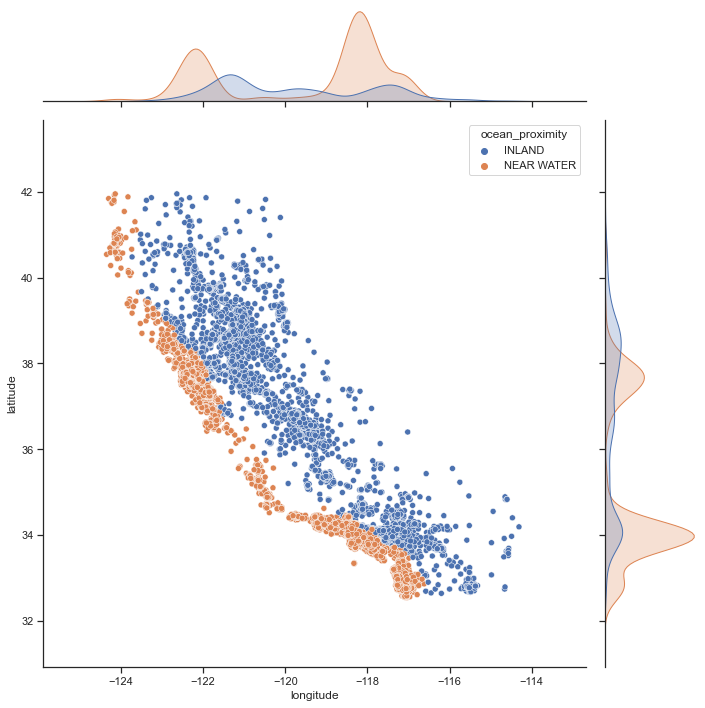

In [368]:
# Verteilung von ocean_proximity auf Geokoordinaten visualisieren
sns.jointplot(data=train_dataset, x='longitude', y='latitude', hue="ocean_proximity",height=10);

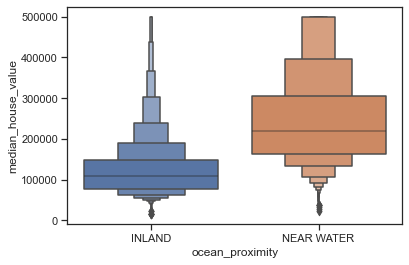

In [369]:
# Untersuchung der kategroialen Variable "ocean_proximity" mit einem erweiterten Boxplot
sns.boxenplot(data=train_dataset, x="ocean_proximity", y="median_house_value");

# Modelling
---

## 1. Linear OLS Regression
---

### Model 1.1 - Linear OLS Regression mit scikit learn

#### Modellierung

Mit den zuvor ausgewählten Variablen testen wir nun das Lineare Regressionsmodell von scikit learn.  
Um die Daten in das für scikit learn benötigte Format zu bringen, führen wir erneut einen datasplit durch. Da wir bereits vom Anfang noch ein Testdatenset haben, wird bei diesem Split ein Validierungsdatenset erzeugt, mit welchem das Modell erst validiert wird, bevor es dann am Ende mit den Testdaten evaluiert wird.

In [370]:
# Auswahl der Features und Split der Trainingsdaten in X und Y Varaiblen
features = ['median_income', 'ocean_proximity', 'bedrooms_per_room', 'people_per_household','housing_median_age']
X1 = train_dataset[features]
y1 = train_dataset["median_house_value"]


In [371]:
# Data Split für Modell Scikitlearn
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2, random_state=0)

In [372]:
# Create pipeline with model
lin_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lin', LinearRegression())
                        ])

In [373]:
# show pipeline
set_config(display="diagram")
# Fit model
lin_pipe.fit(X_train1, y_train1)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F7C1ABE6D0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F7CEB0DC10>)])),
                ('lin', LinearRegression())])

In [374]:
# Obtain model coefficients
lin_pipe.named_steps['lin'].coef_

array([ 83634.3235705 ,  16523.70721509, -16232.45330721,  12342.81207397,
       -33603.07831092,  33603.07831092])

In [375]:
list_numerical = X1.drop(['ocean_proximity'], axis=1).columns

In [376]:
features_names = np.concatenate((list_numerical.to_numpy(), lin_pipe.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out()))
features_names

array(['median_income', 'bedrooms_per_room', 'people_per_household',
       'housing_median_age', 'x0_INLAND', 'x0_NEAR WATER'], dtype=object)

Mit Hilfe der Koeffizienten der ausgewählten Variablen können wir uns die Relevanz grafisch darstellen lassen. So können beim Optimieren des Models gezielt weniger wichtige Features weggelassen werden. So wie aktuell dargestellt haben alle Features zumindest eine gewisse Relevanz. Ein Durchlauf des Models ohne die schwächste Variable *housing_median_age* erzielt kein besseres Ergebnis (Siehe "Evaluation mit Trainingsdaten" unten). Zuvor wurde hier ebenfalls Ausprägungen von *ocean_proximity* als irrelevant dargestellt, was unter anderem Anlass war, im Feature Engineering die Ausprägungen zu *NEAR* *WATER* zusammengefasst wurden.

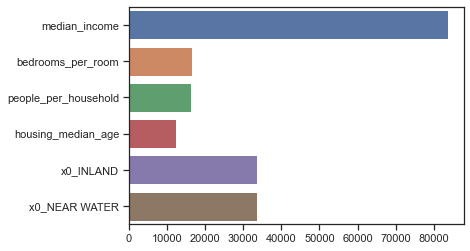

In [377]:
# get absolute values of coefficients
importance = np.abs(lin_pipe.named_steps['lin'].coef_)

sns.barplot(x=importance, 
            y=features_names
            );

#### Evaluation mit Trainingsdaten

In [378]:
y_pred1train = lin_pipe.predict(X_train1)

In [379]:
y_pred1train

array([416076.67957139, 254530.64297383, 201335.73206234, ...,
       113675.58919158, 404117.08422568, 152155.08694092])

In [380]:
print('r2 in %:', r2_score(y_train1, y_pred1train)*100)
print('MSE:', mean_squared_error(y_train1, y_pred1train))
print('RMSE:', mean_squared_error(y_train1, y_pred1train, squared=False))

r2 in %: 62.59503206786563
MSE: 5031965114.543374
RMSE: 70936.34551161608


Ein Ergebnis von r2 = 62,62% und einem RMSE von 70712 ist kein besonders gutes Ergebnis. Das Modell weicht im Schnitt 70712$ vom eigentlichen *median_house_value* ab, welcher sich meistens zwischen 100.000 und 500.000$ bewegt. Als Versuch wurde das schwächste Feature *housing_median_age* entfernt, das Ergebnis fiel dabei leicht schlechter aus:  

Modell ohne *housing_median_age*:  
- r2 in %: 61.742949278293366  
- MSE: 5117358064.557615  
- RMSE: 71535.71181275556  


#### Validierung mit Testdaten

Nun wird das Modell mit dem Validation dataset validiert.

In [381]:
y_pred1val = lin_pipe.predict(X_val1)

In [382]:
print('r2 in %:', r2_score(y_val1, y_pred1val)*100)
print('MSE:', mean_squared_error(y_val1, y_pred1val))
print('RMSE:', mean_squared_error(y_val1, y_pred1val, squared=False))

r2 in %: 60.12220550458062
MSE: 5246250124.666709
RMSE: 72431.00251043547


Das Ergebnis der Validierung fällt noch schlechter aus.
Das Modell ist also nicht gut genug gefittet, also underfitted. Nun kann entweder das Modell angepasst werden (bspw. andere Varaiblen gewählt werden) oder ein anderes Modell getestet werden um auf ein besseres Ergebnis zu kommen. Da nach verschiedenen Tests kein bessere Kombination an Features gefunden werden konnte, werden zunächst andere Modelle getestet.

### Model 1.2 - Linear OLS Regression with Statsmodels

#### Modellierung

Für das Linear Regression Modell von statsmodels ist kein erneuter datasplit notwendig, das Modell kann mit dem train_dataset arbeiten, welches X und Y Variablen enthält. Auf die seperate Erstellung eines Validation Datasets wird hier verzichtet, das Modell wird lediglich mit den Traingsdaten und schließlich mit den Testdaten evaluiert.

In [383]:

lm1 = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + bedrooms_per_room + people_per_household + housing_median_age', data=train_dataset).fit()


In [384]:
# Short summary
lm1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-6.134e+04,4227.647,-14.509,0.000,-6.96e+04,-5.31e+04
ocean_proximity[T.NEAR WATER],6.744e+04,1355.990,49.735,0.000,6.48e+04,7.01e+04
median_income,4.351e+04,405.883,107.208,0.000,4.27e+04,4.43e+04
bedrooms_per_room,2.849e+05,1.29e+04,22.057,0.000,2.6e+05,3.1e+05
people_per_household,-1.174e+04,439.002,-26.751,0.000,-1.26e+04,-1.09e+04
housing_median_age,973.1340,46.419,20.964,0.000,882.148,1064.120


In [385]:
# Full summary
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     5372.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:59:26   Log-Likelihood:            -2.0583e+05
No. Observations:               16346   AIC:                         4.117e+05
Df Residuals:                   16340   BIC:                         4.117e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -6.134e+04   4227.647    -14.509      0.000   -6.96e+04   -5.31e+04
ocean_proximity[T.NEAR WATER]  6.744e+04   1355.990     49.735      0.000    6.48e+04    7.01e+04
median_income                  4.351e+04    405.883    107.208      0.000    4.27e+04    4.43e+04
bedrooms_per_room              2.849e+05   1.29e+04     22.057      0.000     2.6e+05     3.1e+05
people_per_household          -1.174e+04    439.002    -26.751      0.000   -1.26e+04   -1.09e+04
housing_median_age              973.1340     46.419     20.964      0.000     882.148    1064.120
==============================================================================
Omnibus:                     5352.896   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35565.746
Skew:                           1.410   Prob(JB):                         0.00
Kurtosis:                       9.653   Cond. No.                         761.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [386]:
print("RMSE", np.sqrt(lm1.mse_resid))

RMSE 71187.88381161772


Das Modell weißt schon einen ähnlichen r2 value auf wie das scikit learn Modell. Die gewählten Features scheinen sinnvoll gewählt zu sein, da keine einen P-Value von größer 0,05 besitzt. Damit können wir die Null Hypothese verwerfen und davon ausgehen, dass die Features Einfluss auf unsere Y Variable haben.  
 
Mehrere Tests ergeben, dass das Löschen von Variablen (getestet wurde ohne *housing_median_age* und *people_per_household*) negativen Einfluss auf den Erfolg des Modells hat.  

Bevor die Ergebnisse weiter interpretiert werden, soll zunächste ein Optimierung durch die Entfernung von Outliern stattfinden. Die Outlier werden durch die Methode "Cook's Distance" identifiziert.

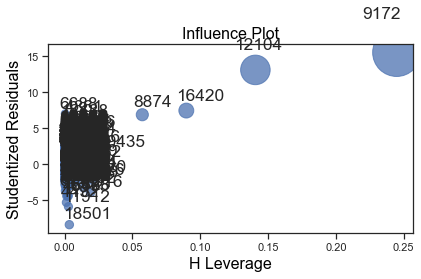

In [387]:
# Visualisierung der Outlier nach Cook's Distance
fig = sm.graphics.influence_plot(lm1, criterion="cooks")
fig.tight_layout(pad=1.0)

In [388]:
# Berechnen der Outlier nach Cook's Distance
# obtain Cook's distance 
lm1_cooksd = lm1.get_influence().cooks_distance[0]

# get length of df to obtain n
n = len(train_dataset["median_income"])

# calculate critical d
critical_d = 4/n
print('Critical Cooks distance:', critical_d)

# identification of potential outliers with leverage
out_d = lm1_cooksd > critical_d

# output potential outliers with leverage
print(train_dataset.index[out_d], "\n", 
    lm1_cooksd[out_d])

Critical Cooks distance: 0.0002447081854888046
Int64Index([10574, 17237,  4643,  4592,  5288, 15700, 17108,  8857,  5464,
             5466,
            ...
            12341,  4065, 15641, 20091,  4245,  5282,   199,    59, 16835,
             8767],
           dtype='int64', length=819) 
 [2.28113130e-03 3.46736799e-04 7.94212143e-04 9.41437453e-04
 2.91710354e-04 7.17529070e-04 3.33664252e-03 2.70405840e-04
 7.29870656e-04 4.15292631e-04 3.32549018e-04 6.77643128e-04
 3.76883632e-04 1.02646758e-03 3.12792105e-04 1.79005733e-03
 6.28543151e-04 8.79664957e-04 1.53323253e-02 3.61463664e-03
 6.19814958e-04 5.89325545e-04 3.02288089e-04 3.30204643e-04
 1.98353122e-03 8.01140772e-04 2.86265393e-04 2.87592302e-04
 1.02454185e-03 2.51142736e-04 2.49464954e-04 3.83435086e-04
 3.73039136e-04 5.34194711e-04 5.41784732e-04 8.97536210e-04
 1.98810692e-03 9.40109212e-04 9.38722526e-04 1.91188605e-03
 3.39591233e-04 3.69032607e-04 2.67207283e-04 3.19858729e-03
 4.13736858e-04 3.31731633e-04 4.7104

Um das Trainingsdatenset noch für weitere Modelle verwenden zu können ohne es neu erzeugen zu müssen, wird an dieser Stelle ein neues Datenset erstellt.

In [389]:
# droppen der Outlier Observations
train_dataset2=train_dataset.drop(train_dataset.index[out_d])

Nun wird der Algorithmus erneut durchgeführt, auf Basis des bereinigten datasets.

In [390]:
lm2 = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + bedrooms_per_room + people_per_household + housing_median_age', data=train_dataset2).fit()

In [391]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     8934.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:00:22   Log-Likelihood:            -1.9102e+05
No. Observations:               15527   AIC:                         3.821e+05
Df Residuals:                   15521   BIC:                         3.821e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -5.056e+04   4114.530    -12.288      0.000   -5.86e+04   -4.25e+04
ocean_proximity[T.NEAR WATER]  5.872e+04   1071.584     54.795      0.000    5.66e+04    6.08e+04
median_income                  4.821e+04    372.767    129.335      0.000    4.75e+04    4.89e+04
bedrooms_per_room              3.572e+05   1.21e+04     29.524      0.000    3.33e+05    3.81e+05
people_per_household          -2.626e+04    567.689    -46.264      0.000   -2.74e+04   -2.52e+04
housing_median_age              907.5866     36.666     24.753      0.000     835.716     979.457
==============================================================================
Omnibus:                     1138.759   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1550.133
Skew:                           0.636   Prob(JB):                         0.00
Kurtosis:                       3.881   Cond. No.                         920.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [392]:
print("RMSE", np.sqrt(lm2.mse_resid))

RMSE 53300.59730084918


Folgende Erkenntnisse lassen sich hier gewinnen:
- Der r2 hat sich um 12% verbessert. 74,2% Abweichung kann durch das Modell erklärt werden.
- F-Statistic gibt uns einen Überblick über das Modell im Vehältnis zum Fehler im Modell ( Verhältnis von "wie sehr hat das Modell die Vorhersage des Ergebnisses verbessert vs. Abweichungen/Fehler des Modells). Wenn die Vebesserung überwiegt, entsteht ein großer F Wert, was hier der Fall ist.
- AIC und BIC haben sich auch verbessert nach der Entferung der Outlier.
- Die Normalverteilung der residuals kann über Omnibus und Jarque-Bera analysiert werden, ist in diesem Fall mit einem Datensatz mit weit mehr als 50 Observations allerdings zu vernachlässigen.
- Aus einem Durbin-Watson Wert nahe 2 kann man erkennen, dass keine autocorrelation vorliegt.
- der RMSE hat sich auch verbessert und ist um einiges besser als der RMSE im scikit learn Modell

### Regression Diagnostics

In diesem Abschnitt soll nun noch einmal verstärkt die Auswirkung der einzelnen Features auf unser Modell sowie mögliche Outlier untersucht werden.

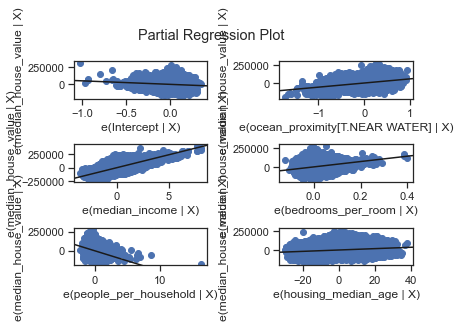

In [393]:
fig = sm.graphics.plot_partregress_grid(lm2)
fig.tight_layout(pad=1.0)

Auf dem Partial Regression Plot können wir jeweils einen mehr oder weniger linearen Zusammenhang der Features auf die Y Variable erkennen.

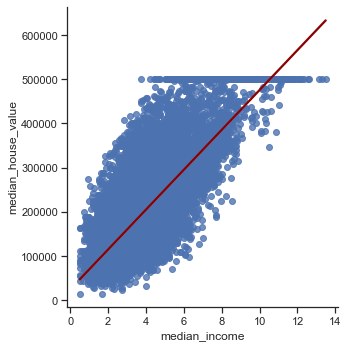

In [394]:
sns.lmplot(x='median_income', y='median_house_value', data=train_dataset2, line_kws={'color': 'darkred'}, ci=False);

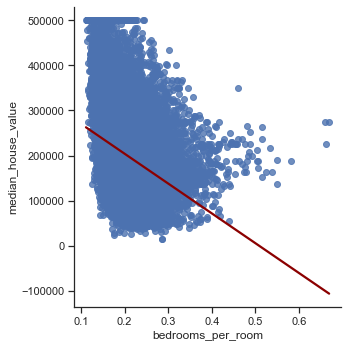

In [395]:
sns.lmplot(x='bedrooms_per_room', y='median_house_value', data=train_dataset2, line_kws={'color': 'darkred'}, ci=False);

Da bereits im Feature Engineering sowie durch Cook's Distance starke Outlier entfernt wurden, sind hier keine Outlier mehr mit bspw. besonders starkem Hebel zu erkennen.

In [396]:
train_dataset2

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,people_per_household,bedrooms_per_household,rooms_per_household,bedrooms_per_room
14740,-117.05,32.58,22.0,2101,399,1551,371,4.1518,136900.0,NEAR WATER,4.180593,1.075472,5.663073,0.189910
10101,-117.97,33.92,32.0,2620,398,1296,429,5.7796,241300.0,NEAR WATER,3.020979,0.927739,6.107226,0.151908
20566,-121.84,38.65,29.0,3167,548,1554,534,4.3487,200700.0,INLAND,2.910112,1.026217,5.930712,0.173034
2670,-115.60,33.20,37.0,709,187,390,142,2.4511,72500.0,INLAND,2.746479,1.316901,4.992958,0.263752
15709,-122.43,37.79,25.0,1637,394,649,379,5.0049,460000.0,NEAR WATER,1.712401,1.039578,4.319261,0.240684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,-118.38,34.15,36.0,2933,619,1115,579,4.3036,365900.0,NEAR WATER,1.925734,1.069085,5.065630,0.211047
7616,-118.22,33.86,16.0,8732,1489,3944,1493,5.1948,203500.0,NEAR WATER,2.641661,0.997321,5.848627,0.170522
16388,-121.30,38.05,52.0,122,26,62,25,1.1500,112500.0,INLAND,2.480000,1.040000,4.880000,0.213115
19949,-119.37,36.21,35.0,2228,476,1567,449,1.4455,54100.0,INLAND,3.489978,1.060134,4.962138,0.213645


In [397]:
y_pred2 = lm2.predict(train_dataset2)

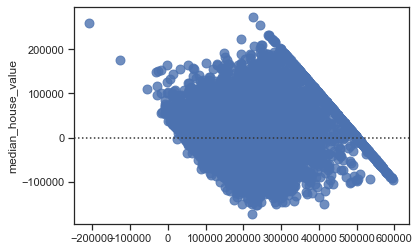

In [398]:
sns.residplot(x=y_pred2, y="median_house_value", data=train_dataset2, scatter_kws={"s": 80});

Im residplot sollten im Optimalfall die residuals einigermaßen gleichmäßig zufällig um die horizontale Nulllinie verteilt sein.
Da dies nicht ganz der Fall ist, könnte es auf heteroscedasticity hindeuten. Das bedeutet, dass die Error im Modell nicht gleichmäßig verteilt sind.

Um das zu überprüfen, wird der Breusch-Pagan Lagrange Multiplier Test angewendet. Die Null Hypothese hierbei ist homoscedasticity.

In [399]:
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sm.stats.het_breuschpagan(lm2.resid, lm2.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 933.4828238955702),
 ('p-value', 1.5071399882460282e-199),
 ('f-value', 198.56196055885547),
 ('f p-value', 8.121999469744528e-206)]

Da alle P-Values über 0,05 liegen können wir die Null-Hypothese akzeptieren, was auf homoscedasticity hindeutet.

Im Detail lassen sich auch noch einzelne Variablen untersuchen, was hier lediglich an der einflussreichsten Variablen *median_income* durchgeführt werden soll. Die folgende Funktion liefert mehrere Plots für eine Variable:
- Y and Fitted vs. X: Die auf Basis von *median_income* gefitteten Werte bewegen sich in einem ähnlichen Bereich wie unsere Y Variable
- Partial Regression & CCPR Plot deuten auf ein lineares Verhältnis von *median_income* auf Y hin

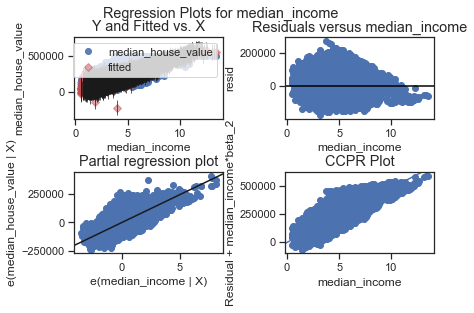

In [400]:
# Regression diagnostics für Variable "median_income"
fig = sm.graphics.plot_regress_exog(lm2, "median_income")
fig.tight_layout(pad=0.2)

## 2. Lasso Regression mit scikit learn
---

Für das Lasso Modell muss wieder nach scikit learn Logik ein datasplit durchgeführt werden.

#### Lasso - Split Data

In [401]:
# Erstellen der X und Y Variablen
y2 = train_dataset2['median_house_value']
features = ['median_income', 'people_per_household', 'ocean_proximity', 'bedrooms_per_room', 'housing_median_age']
X2 = train_dataset2[features]

In [402]:
# Data split
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.3, random_state=0)

#### Lasso - Model

Bei der ersten Durchführung des Modells setzen wir den Alpha Wert standardmäßig auf 1. Dieser wird später noch optimiert.

In [403]:

# Erstellen der Pipeline mit Lasso Modell
lasso_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(alpha=1))
                        ])

In [404]:
# Fitten von Pipeline/Modell
lasso_pipe.fit(X_train2, y_train2)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F7C1ABE6D0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F7CEB0DC10>)])),
                ('lasso', Lasso(alpha=1))])

Um die Importance der einzelnen Features im Lasso Algorithmus zu visualisieren, wird an dieser Stelle eine Liste mit allen Feature Namen erstellt.

In [405]:
# Erstellen einer Liste der numerical features
list_numerical = X2.drop(['ocean_proximity'], axis=1).columns
list_numerical

Index(['median_income', 'people_per_household', 'bedrooms_per_room',
       'housing_median_age'],
      dtype='object')

In [406]:
# Erstellen einer Liste aller Feature Namen
feature_names = np.concatenate((list_numerical.to_numpy(), lasso_pipe.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out()))
feature_names

array(['median_income', 'people_per_household', 'bedrooms_per_room',
       'housing_median_age', 'x0_INLAND', 'x0_NEAR WATER'], dtype=object)

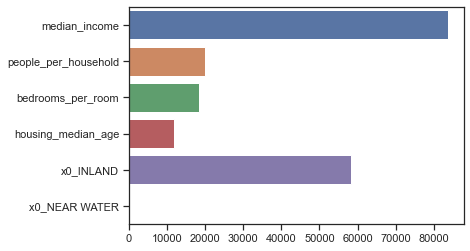

In [407]:
# get absolute values of coefficients
importance = np.abs(lasso_pipe.named_steps['lasso'].coef_)

sns.barplot(x=importance, 
            y=feature_names);

#### Lasso - Model Evaluation

Bevor es an die Optimierung geht, soll zuerst das Modell noch mit dem Wert alpha = 1 evaluiert werden.

In [408]:
pred_train = lasso_pipe.predict(X_train2)
pred_val = lasso_pipe.predict(X_val2)

In [409]:
print('R squared training set', round(lasso_pipe.score(X_train2, y_train2)*100, 2))
print('R squared validation set', round(lasso_pipe.score(X_val2, y_val2)*100, 2))
print('RMSE train set', round(mean_squared_error(y_train2, pred_train, squared=False),2))
print('RMSE validation set', round(mean_squared_error(y_val2, pred_val, squared=False),2))


R squared training set 73.9
R squared validation set 74.89
RMSE train set 53097.18
RMSE validation set 53753.5


In [410]:
# Training data
pred_train = lasso_pipe.predict(X_train2)
mse_train = mean_squared_error(y_train2, pred_train)
print('MSE training set', round(mse_train, 2))

# Validation data
pred_test = lasso_pipe.predict(X_val2)
mse_test =mean_squared_error(y_val2, pred_val)
print('MSE validation set', round(mse_test, 2))

MSE training set 2819310917.08
MSE validation set 2889438999.32


#### Lasso - k-fold cross validation

Nun soll mit Hilfe der k-fold Cross Validation Methode der optimale Wert für alpha ermittelt werden, um unser Modell weiter zu optimieren.

In [411]:
# Erstellen von Modell mit Pipeline
lassoCV_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lassoCV', LassoCV(cv=5, random_state=0, max_iter=10000))
                        ])

In [412]:
# Fit model
lassoCV_pipe.fit(X_train2, y_train2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F7C1ABE6D0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F7CEB0DC10>)])),
                ('lassoCV', LassoCV(cv=5, max_iter=10000, random_state=0))])

In [413]:
lassoCV_pipe.named_steps['lassoCV'].alpha_

78.1184746941765

Der ermittelte optimale Wert alpha liegt bei 80.62796500840743

#### Lasso - Lasso Best

Der ermittelte Optimalwert für alpha wird nun in das Modell eingesetzt.

In [414]:
# Create pipeline with model
lassobest_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lassobest', Lasso(alpha=lassoCV_pipe.named_steps['lassoCV'].alpha_))
                            ])

In [415]:
# Set best alpha

lassobest_pipe.fit(X_train2, y_train2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F7C1ABE6D0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F7CEB0DC10>)])),
                ('lassobest', Lasso(alpha=78.1184746941765))])

Zur Berechnung des RMSE werden auch mit dem Modell lassobest_pipe Predictions berechnet.


In [416]:
pred_trainbest = lassobest_pipe.predict(X_train2)
pred_valbest = lassobest_pipe.predict(X_val2)

In [417]:
#Werte mit optimalem alpha:
print('mit lasso best:')
print('R squared training set ', round(lassobest_pipe.score(X_train2, y_train2)*100, 2))
print('R squared validation set ', round(lassobest_pipe.score(X_val2, y_val2)*100, 2))
print('RMSE train set', round(mean_squared_error(y_train2, pred_trainbest, squared=False),2))
print('RMSE validation set', round(mean_squared_error(y_val2, pred_valbest, squared=False),2))

mit lasso best:
R squared training set  73.9
R squared validation set  74.88
RMSE train set 53097.67
RMSE validation set 53757.1


In [418]:
# Werte ohne optimales alpha:
print('ohne Lasso best:')
print('R squared training set lasso ', round(lasso_pipe.score(X_train2, y_train2)*100, 2))
print('R squared validation set lasso ', round(lasso_pipe.score(X_val2, y_val2)*100, 2))
print('RMSE train set', round(mean_squared_error(y_train2, pred_train, squared=False),2))
print('RMSE validation set', round(mean_squared_error(y_val2, pred_val, squared=False),2))

ohne Lasso best:
R squared training set lasso  73.9
R squared validation set lasso  74.89
RMSE train set 53097.18
RMSE validation set 53753.5


**Fazit**: Durch die best alpha Optimierung hat sich das Ergebnis unseres Modells nicht verbessert, lediglich der RMSE ist kaum merklich besser geworden. Ein r2 von ca. 73% und ein RMSE von ca 53.000 ist ähnlich gut wie das Linear Regression Modell mit statsmodels.

## 3. Splines
---

### 3.1 Splines mit scikit learn

Für das scikit leran Modell wird wieder der übliche datasplit durchgeführt.

In [419]:
y3 = train_dataset[['median_house_value']]
X3 = train_dataset[['median_income', 'ocean_proximity', 'bedrooms_per_room', 'people_per_household', 'housing_median_age']]

In [420]:
# data split
X_train3, X_val3, y_train3, y_val3 = train_test_split(X3, y3, test_size=0.3, random_state=0)

Für das Modell definieren wir die Anzahl der zu platzierenden Knots auf 4. Die Komponente SplineTransformer wird diese Knots dann autoamtisch platzieren.

In [421]:
# Erstellen des Models mit Pipeline. Der Spline Transformer soll 4 Knots platzieren.
splines_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('splines', make_pipeline(SplineTransformer(n_knots=4, degree=3), 
                       Ridge(alpha=1)))
                        ])

In [422]:
splines_pipe.fit(X_train3, y_train3)

y_pred = splines_pipe.predict(X_train3)

Nach dem Erstellen und fitten des Modells wird eine Funktion definiert, um den RMSE auszugeben.

In [423]:
# Erstellen der Funktion model_results um KPIs auszugeben
def model_results(model_name):

    # Training data
    pred_train = splines_pipe.predict(X_train3)
    rmse_train = round(mean_squared_error(y_train3, pred_train, squared=False),4)

    # Test data
    pred_val = splines_pipe.predict(X_val3)
    rmse_val =round(mean_squared_error(y_val3, pred_val, squared=False),4)

    # Print model results
    result = pd.DataFrame(
        {"model": model_name, 
        "rmse_train": [rmse_train], 
        "rmse_val": [rmse_val]}
        )
    
    return result;

In [424]:
model_results(model_name = "spline sklearn")

,model,rmse_train,rmse_val
0,spline sklearn,66611.8676,66620.3066


In [425]:
print('R squared training set', round(splines_pipe.score(X_train3, y_train3)*100, 2))
print('R squared validation set', round(splines_pipe.score(X_val3, y_val3)*100, 2))

R squared training set 66.86
R squared validation set 66.89


Sowohl der r2 Wert als auch der RMSE des Modells liegen hinter dem der vorherigen Modelle mit statsmodels.

In [426]:
# Create observations
x_new = np.linspace(X_val3.min(),X_val3.max(), 100)
x_new = pd.DataFrame(x_new, columns=X3.drop(["ocean_proximity"], axis=1).columns)
x_new = x_new.assign(ocean_proximity=lambda x_new: "dummy")

C:\Users\olive\AppData\Local\Temp/ipykernel_27644/1056164967.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x_new = np.linspace(X_val3.min(),X_val3.max(), 100)


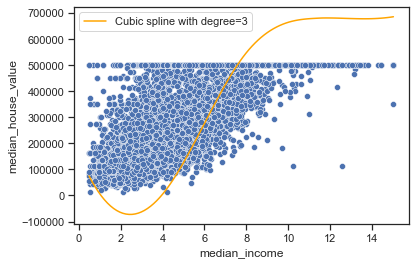

In [427]:
pred = splines_pipe.predict((x_new))

sns.scatterplot(x=X_train3['median_income'], y=y_train3["median_house_value"])

plt.plot(x_new["median_income"], pred, label='Cubic spline with degree=3', color='orange')
plt.legend();

#### Test mit Cook's Distance bereinigten Dataset

Da dieses Splines Modell das vielversprechendste ist, wird das Modell als Test noch einmal mit den per Cook's Distance bereinigten Trainingsdaten gefittet und evaluiert.

In [428]:
y5 = train_dataset2[['median_house_value']]
X5 = train_dataset2[['median_income', 'ocean_proximity', 'bedrooms_per_room', 'people_per_household', 'housing_median_age']]

In [429]:
# data split
X_train5, X_val5, y_train5, y_val5 = train_test_split(X5, y5, test_size=0.3, random_state=0)

In [430]:
# Erstellen des Models mit Pipeline. Der Spline Transformer soll 4 Knots platzieren.
splinesCD_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('splines', make_pipeline(SplineTransformer(n_knots=4, degree=3), 
                       Ridge(alpha=1)))
                        ])

In [431]:
splinesCD_pipe.fit(X_train5, y_train5)

y_pred = splinesCD_pipe.predict(X_train5)

In [432]:
# Erstellen der Funktion model_results um KPIs auszugeben
def model_results(model_name):

    # Training data
    pred_train = splinesCD_pipe.predict(X_train5)
    rmse_train = round(mean_squared_error(y_train5, pred_train, squared=False),4)

    # Test data
    pred_val = splinesCD_pipe.predict(X_val5)
    rmse_val =round(mean_squared_error(y_val5, pred_val, squared=False),4)

    # Print model results
    result = pd.DataFrame(
        {"model": model_name, 
        "rmse_train": [rmse_train], 
        "rmse_val": [rmse_val]}
        )
    
    return result;

In [433]:
model_results(model_name = "spline sklearn")

,model,rmse_train,rmse_val
0,spline sklearn,52272.2565,52687.1737


In [434]:
print('R squared training set', round(splinesCD_pipe.score(X_train5, y_train5)*100, 2))
print('R squared validation set', round(splinesCD_pipe.score(X_val5, y_val5)*100, 2))

R squared training set 74.7
R squared validation set 75.87


Das Resultat ist um einiges besser als im vorherigen Versuch. Ob das Modell mit den originalen Testdaten auch so gut abschneidet muss allerdings erst evaluiert werden.

### 3.2 Cubic Spline with Patsy & Statsmodels

In [435]:
y4 = train_dataset[['median_house_value']]
X4 = train_dataset[['median_income']]

In [436]:
# data split
X_train4, X_val4, y_train4, y_val4 = train_test_split(X4, y4, test_size=0.3, random_state=0)

In [437]:
# Erstellen eines cubic spline mit 3 manuell platzierten knots bei 1, 4 und 7
transformed_x = dmatrix(
            "bs(train, knots=(1,4,7), degree=3, include_intercept=False)", 
                {"train": X_train4},return_type='dataframe')

In [438]:
# Fitten des linearen models an das transformierte dataset
spline2 = sm.GLM(y_train4, transformed_x).fit()

In [439]:
# Training data
pred_train = spline2.predict(dmatrix("bs(train, knots=(1,4,7), include_intercept=False)", {"train": X_train4}, return_type='dataframe'))
rmse_train = mean_squared_error(y_train4, pred_train, squared=False)

# Validation data
pred_val = spline2.predict(dmatrix("bs(val, knots=(1,4,7), include_intercept=False)", {"val": X_val4}, return_type='dataframe'))
rmse_val =mean_squared_error(y_val4, pred_val, squared=False)

# Save model results
model_results = pd.DataFrame(
    {
    "model": "Cubic spline",  
    "rmse_train": [rmse_train], 
    "rmse_val": [rmse_val]
    })

model_results

,model,rmse_train,rmse_val
0,Cubic spline,82755.707542,83552.807458


In [440]:
print('R squared training set', round(r2_score(y_train4, pred_train)*100, 2))
print('R squared validation set', round(r2_score(y_val4, pred_val)*100, 2))

R squared training set 48.84
R squared validation set 47.93


In diesem Modell ist sowohl der r2 Wert als auch der RMSE sehr viel schlechter als in den übrigen Modellen. Dies überrascht nicht, da in diesem Modell nur eine X Variable zur Vorhersage verwendet wurde.

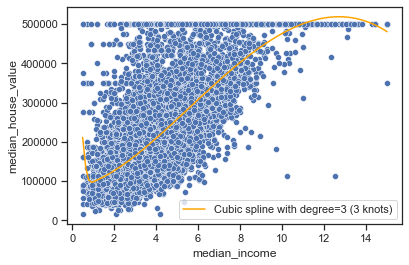

In [441]:
# Create observations
xp = np.linspace(X_val4.min(),X_val4.max(), 100)
# Make some predictions
pred = spline2.predict(dmatrix("bs(xp, knots=(1,4,7), include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# plot
sns.scatterplot(x=X_train4['median_income'], y=y_train4['median_house_value'])

plt.plot(xp, pred, label='Cubic spline with degree=3 (3 knots)', color='orange')
plt.legend();

### 3.3 Natural Spline with Patsy & Statsmodels

In [442]:
transformed_x3 = dmatrix("cr(train,df = 3)", {"train": X_train4}, return_type='dataframe')

spline3 = sm.GLM(y_train3, transformed_x3).fit()

In [443]:
# Training data
pred_train = spline3.predict(dmatrix("cr(train, df=3)", {"train": X_train4}, return_type='dataframe'))
rmse_train = mean_squared_error(y_train4, pred_train, squared=False)

# Validation data
pred_val = spline3.predict(dmatrix("cr(val, df=3)", {"val": X_val4}, return_type='dataframe'))
rmse_val = mean_squared_error(y_val4, pred_val, squared=False)

# Save model results
model_results_ns = pd.DataFrame(
    {
    "model": "Natural spline (ns)",  
    "rmse_train": [rmse_train], 
    "rmse_val": [rmse_val]
    })

model_results_ns

,model,rmse_train,rmse_val
0,Natural spline (ns),83727.928042,84043.715646


In [444]:
print('R squared training set', round(r2_score(y_train4, pred_train)*100, 2))
print('R squared test set', round(r2_score(y_val4, pred_val)*100, 2))

R squared training set 47.63
R squared test set 47.31


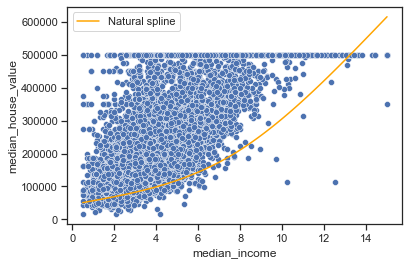

In [445]:
# Make predictions
pred = spline3.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))
xp = np.linspace(X_val4.min(),X_val4.max(), 100)
# plot
sns.scatterplot(x=X_train4['median_income'], y=y_train4['median_house_value'])
plt.plot(xp, pred, color='orange', label='Natural spline')
plt.legend();

# Abschließende Evaluation mit Testdaten

## Transformation Testdaten

Um die Testdaten verwenden zu können, müssen die gleichen Schritte zur Transformation durchgeführt werden wie mit den Traindaten (ANpassung Datentypen, droppen NULL values, Erzeugen von selbst erstellten Features)

In [446]:
test_dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
10,-122.26,37.85,52.0,2202,434.0,910,402,3.2031,281500.0,NEAR BAY,above
13,-122.26,37.84,52.0,696,191.0,345,174,2.6736,191300.0,NEAR BAY,above
19,-122.27,37.84,52.0,1503,298.0,690,275,2.6033,162900.0,NEAR BAY,above
28,-122.28,37.84,50.0,2082,492.0,1131,473,1.6424,108900.0,NEAR BAY,below
40,-122.26,37.83,52.0,1665,419.0,946,395,2.0978,155400.0,NEAR BAY,above
...,...,...,...,...,...,...,...,...,...,...,...
20605,-121.58,39.12,26.0,2796,629.0,2017,632,1.8355,61200.0,INLAND,above
20609,-121.56,39.11,18.0,2171,480.0,1527,447,2.3011,57500.0,INLAND,above
20620,-121.48,39.05,40.0,198,41.0,151,48,4.5625,100000.0,INLAND,below
20622,-121.44,39.00,20.0,755,147.0,457,157,2.4167,67000.0,INLAND,above


In [447]:
# droppen von NULL Values
test_dataset = test_dataset.dropna()

In [448]:
# nicht benötigte Variable droppen
test_dataset = test_dataset.drop(columns=['price_category'])

In [449]:
# Anpassung der datatypes
test_dataset['median_house_value'] = test_dataset['median_house_value'].astype("float64")
test_dataset['housing_median_age'] = test_dataset['housing_median_age'].astype("float64")
test_dataset['total_bedrooms'] = test_dataset['total_bedrooms'].astype("int64")
test_dataset['ocean_proximity'] = test_dataset['ocean_proximity'].astype("category")

In [450]:
# erzeugen der selbst erstellten Features
test_dataset=test_dataset.assign(people_per_household=lambda test_dataset: test_dataset.population/test_dataset.households)
test_dataset=test_dataset.assign(bedrooms_per_household=lambda test_dataset: test_dataset.total_bedrooms/test_dataset.households)
test_dataset=test_dataset.assign(rooms_per_household=lambda test_dataset: test_dataset.total_rooms/test_dataset.households)
test_dataset=test_dataset.assign(bedrooms_per_room=lambda test_dataset: test_dataset.total_bedrooms/test_dataset.total_rooms)

In [451]:
# Zusammenfassung des Features ocean_proximity
test_dataset.ocean_proximity = test_dataset.ocean_proximity.str.replace("ISLAND", "NEAR WATER", regex =True)
test_dataset.ocean_proximity = test_dataset.ocean_proximity.str.replace("NEAR BAY", "NEAR WATER", regex =True)
test_dataset.ocean_proximity = test_dataset.ocean_proximity.str.replace("NEAR OCEAN", "NEAR WATER", regex =True)
test_dataset.ocean_proximity = test_dataset.ocean_proximity.str.replace("<1H OCEAN", "NEAR WATER", regex =True)

In [452]:
# Korrektur des datatype von ocean_proximity
test_dataset['ocean_proximity'] = test_dataset['ocean_proximity'].astype("category")

## Test Data Split

Um die Testdaten in der Evaluation für bestimmte Modelle verwenden zu können, müssen diese nach Features und vorherzusagender Varaible aufgeteilt werden.

In [467]:
#X = test_dataset.drop(["median_house_value"], axis=1)
#y= test_dataset["median_house_value"]
y = test_dataset['median_house_value']
features = ['median_income', 'people_per_household', 'ocean_proximity', 'bedrooms_per_room', 'housing_median_age']
X = test_dataset[features]

## Finale Evaluation

Zur finalen Evaluation mit den Testdaten werden die besten Modelle ausgewählt:
1. Lineare Regression mit statsmodels
2. Lasso Regression mit scikit learn
3. Splines mit scikit learn

### Evaluation Lineares Regressionsmodell mit statsmodels

In [468]:
pred_test = lm2.predict(X)

In [469]:
print('R squared test set', round(r2_score(y, pred_test)*100, 2))
print('RMSE test set', round(mean_squared_error(y, pred_test, squared=False),2))

RMSE test set 69665.64
R squared test set 62.77


Die Ergebnisse mit den Testdaten sind schlechter als die Resultate mit den bearbeiteten Trainingsdaten. Dies liegt vermutlich am Entfernen vieler Outlier durch Cook's Distance.

### Evaluation Lasso Regression mit scikit learn

In [470]:
pred_testfinal = lassobest_pipe.predict(X)

In [471]:
print('Testergebnis mit lasso best:')
print('R squared test set ', round(lassobest_pipe.score(X, y)*100, 2))
print('RMSE test set', round(mean_squared_error(y, pred_testfinal, squared=False),2))

Testergebnis mit lasso best:
R squared test set  35.76
RMSE test set 91509.58


### Evaluation Splines mit scikit learn

In [476]:
y_pred = splines_pipe.predict(X)

In [489]:
# Erstellen der Funktion model_results um KPIs auszugeben
def model_results(model_name):

    # Training data
    pred_train = splinesCD_pipe.predict(X_train5)
    rmse_train = round(mean_squared_error(y_train5, pred_train, squared=False),4)

    # Test data
    pred_val = splinesCD_pipe.predict(X)
    rmse_val =round(mean_squared_error(y, pred_val, squared=False),4)

    # Print model results
    result = pd.DataFrame(
        {"model": model_name, 
        "rmse_train": [rmse_train], 
        "rmse_test": [rmse_val]}
        )
    
    return result;

In [490]:
model_results(model_name = "spline sklearn")

,model,rmse_train,rmse_test
0,spline sklearn,52272.2565,65233.9997


In [488]:
print('R squared test set', round(splinesCD_pipe.score(X, y)*100, 2))

R squared test set 67.36


Das Modell, welches mit dem Cook's Distance optimierten Traindataset gefitted wurde, erzielt in der Evaluation mit den Testdaten leicht bessere Ergebnisse.

Zum Vergleich die KPIs ohne Cook's Distance Optimierung:  
- RMSE: 66017.6385  
- r2: 66.57  